# Correlations and Chi squared

This script finds the correlations between numerical features of the data and performs a chi-squared test on all data variables

In [1]:
import numpy as np
import pandas as pd
import datetime
import os
import glob
import json
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# set variables from config file
config_path = os.path.abspath('..')

with open(config_path + '\config-example.json', 'r') as f:
    config = json.load(f)

dataset_audited_fname = config['DEFAULT']['dataset_audited_fname']
processing_path = config['DEFAULT']['processing_path']
dataset_fname_suffix = config['DEFAULT']['dataset_fname_suffix']

In [3]:
client_data = pd.read_csv(os.path.join(processing_path,dataset_audited_fname) + dataset_fname_suffix, header = 0, delimiter = ',',)

C:\Users\KingRemy\AppData\Local\Temp\ipykernel_29472\1252656687.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  client_data = pd.read_csv(os.path.join(processing_path,dataset_audited_fname) + dataset_fname_suffix, header = 0, delimiter = ',',)


In [4]:
client_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 658446 entries, 0 to 658445
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   EventName          658446 non-null  object 
 1   StartDate          658446 non-null  object 
 2   EventType          658446 non-null  object 
 3   BookingReference   658446 non-null  object 
 4   AttendeeReference  658446 non-null  object 
 5   GroupSize          658446 non-null  int64  
 6   IsLeadAttendee     658446 non-null  object 
 7   AttendeeGrossCost  658446 non-null  float64
 8   EventId            658446 non-null  int64  
 9   BookingStatus      658446 non-null  object 
 10  AttendeeType       658446 non-null  object 
 11  StatusCreatedDate  658444 non-null  object 
 12  ClientId           658446 non-null  float64
 13  StartYear          658446 non-null  int64  
 14  StatusCreatedYear  658444 non-null  float64
dtypes: float64(3), int64(3), object(9)
memory usage: 75

In [5]:
# numeric
var_list_num = client_data.select_dtypes(include='number').columns.tolist()

# Categorical
var_list_cat = client_data.select_dtypes(include = ['object', 'category']).columns.tolist()

C:\Users\KingRemy\AppData\Local\Temp\ipykernel_29472\1943907464.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr_client_data_all, dtype=np.bool)


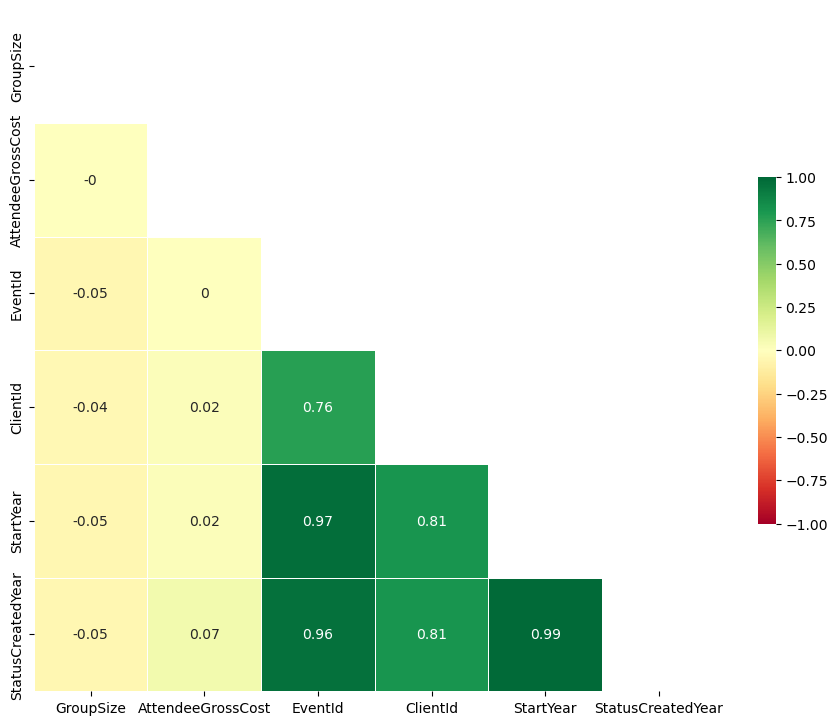

In [6]:
# Correlation 
corr_client_data_all = client_data[var_list_num].corr()

# plot correlations
corr_client_data_all = round(corr_client_data_all,2)
mask = np.zeros_like(corr_client_data_all, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11,9))
sns.heatmap(corr_client_data_all, mask=mask, cmap='RdYlGn', vmin = -1, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.show()

### Categorical features Chi-Squared test of independence between variables in taxonomy
if Chi-squared > crit_value reject the null hypothesis that there is no relationship between both variables.

Uplift is a measure of the uplift between the chi squared metric and the critical value (I am assuming that the larger the uplift. The stronger the relastionship between the features.

In [7]:

def get_chi_squared_all(df):

    ''' 
    Performs a chi-squared test between all variables in the dataframe
    Parameters
      df: a dataframe
    Returns a dataframe
    '''

    results_buffer = {}
    for var1 in client_data.columns.values:
        for var2 in client_data.columns.values:
            if(var1 != var2):
                xtab = pd.crosstab(client_data[var1],client_data[var2])
                res = stats.chi2_contingency(xtab)
                chi_squared_crit_value = stats.chi2.ppf(q = 0.95,               # Find the critical value for 95% confidence 
                                                        df = res[2])            # # Df = number of variable categories - 1
                print(f"\nResults for {var1} and {var2}")
                print(f"\tChi-squared:\t{res[0]}")
                print(f"\tP-value:\t{res[1]}")
                print(f"\tDoF:\t\t{res[2]}")
                print(f"\tCrit-value:\t{chi_squared_crit_value}")
                print(f"\tUplift:\t\t{res[0] / chi_squared_crit_value}")
                results_buffer[(var1, var2)] = (res[0] / chi_squared_crit_value)
    return pd.Series(results_buffer,name = 'uplift').sort_values(ascending = False)

chi2_all = get_chi_squared_all(client_data[var_list_cat])


Results for EventName and StartDate
	Chi-squared:	826353757.2026279
	P-value:	0.0
	DoF:		2492478
	Crit-value:	2496151.603841948
	Uplift:		331.0511092077688

Results for EventName and EventType
	Chi-squared:	13486533.983208315
	P-value:	0.0
	DoF:		38178
	Crit-value:	38633.6498352869
	Uplift:		349.08775227573994

Results for EventName and BookingReference
	Chi-squared:	1197054827.9999816
	P-value:	0.0
	DoF:		595318644
	Crit-value:	595375401.818734
	Uplift:		2.0105883184680726


MemoryError: Unable to allocate 4.46 GiB for an array with shape (329220, 1819) and data type int64

In [57]:
#Function to run a series of chi-squared independance tests for all the
#features against the target
def get_chi_squared_target(df,target,feature_list):
    
    ''' 
    Performs a chi-squared test between specified variables in the dataframe
    Parameters
      df: a dataframe
      target: string, a variable you want to be in every chi-squared
      feature_list: list, the other variables you want to test the target with
    Returns a dataframe
    '''
    
    results_buffer = {}
    for var in feature_list:
        xtab = pd.crosstab(df[target],df[var])
        res = stats.chi2_contingency(xtab)
        chi_squred_crit_value = stats.chi2.ppf(q = 0.95,df = res[2])
        print(f"\nResults for {target} and {var}")
        print(f"\tChi-squared:\t{res[0]}")
        print(f"\tP-value:\t{res[1]}")
        print(f"\tDoF:\t\t{res[2]}")
        print(f"\tCrit-value:\t{chi_squred_crit_value}")
        print(f"\tUplift:\t\t{res[0] / chi_squred_crit_value}")
        results_buffer[var] = (res[0] / chi_squred_crit_value)
    return pd.Series(results_buffer, name = 'uplift').sort_values(ascending = False)


chi2_target = get_chi_squared_target(data,'StartDate',var_list_cat)


Results for StartDate and EventName
	Chi-squared:	89267013.59032354
	P-value:	0.0
	DoF:		184392
	Crit-value:	185392.0156771957
	Uplift:		481.504088858687

Results for StartDate and StartDate
	Chi-squared:	96919272.0
	P-value:	0.0
	DoF:		155236
	Crit-value:	156153.64829669512
	Uplift:		620.666075094521

Results for StartDate and BookingReference
	Chi-squared:	96919272.00000057
	P-value:	0.0
	DoF:		96225832
	Crit-value:	96248651.68950678
	Uplift:		1.0069675813502008

Results for StartDate and AttendeeReference
	Chi-squared:	96919272.00000794
	P-value:	0.46615214193936516
	DoF:		96918090
	Crit-value:	96940991.62185754
	Uplift:		0.9997759500755437

Results for StartDate and IsLeadAttendee
	Chi-squared:	412430.13254552335
	P-value:	0.0
	DoF:		1576
	Crit-value:	1669.4694556353525
	Uplift:		247.04263450484285

Results for StartDate and BookingStatus
	Chi-squared:	4983.089681898183
	P-value:	0.0
	DoF:		786
	Crit-value:	852.332985749568
	Uplift:		5.846411866268322

Results for StartDate and At